# Clustering Analysis on Country Data

This notebook implements K-Means and DBSCAN clustering algorithms on country socio-economic data with dimensionality reduction.


## Section 1: Data Preparation and Setup


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [28]:
# Load and prepare data
df = pd.read_csv('../data/Country-data.csv')
df_clean = df.dropna()
countries = df_clean['country'].copy()
features = df_clean.drop('country', axis=1)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f"Dataset shape: {df_clean.shape}")
print(f"Features: {features.columns.tolist()}")
print(f"Countries: {len(countries)}")


Dataset shape: (167, 10)
Features: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
Countries: 167


In [29]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Apply t-SNE for comparison
tsne = TSNE(n_components=2, perplexity=30, learning_rate=100, max_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features_scaled)

print(f"\nDimensionality reduction completed:")
print(f"PCA shape: {pca_result.shape}")
print(f"t-SNE shape: {tsne_result.shape}")


PCA explained variance: [0.4595174  0.17181626]
Total variance explained: 0.631

Dimensionality reduction completed:
PCA shape: (167, 2)
t-SNE shape: (167, 2)


## Section 2: K-Means Clustering


### (a) Determine Optimal k using Elbow Method and Silhouette Score


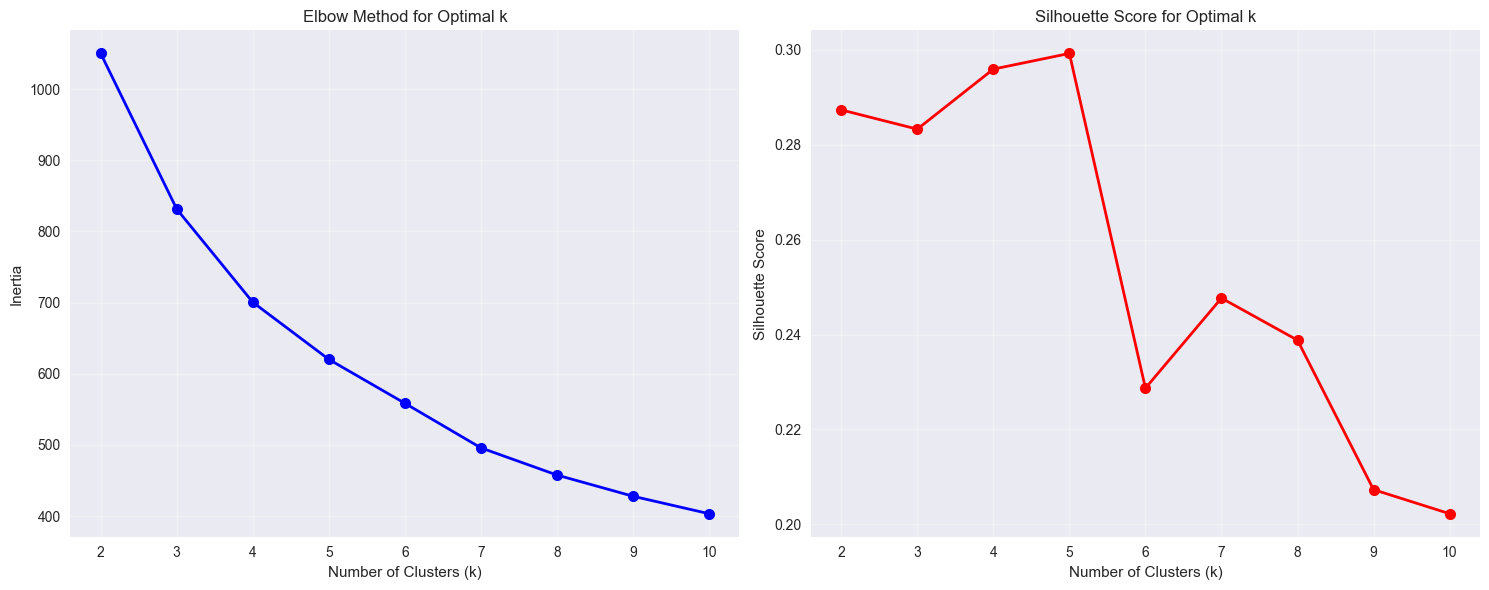

Optimal k (Elbow method): 3
Optimal k (Silhouette score): 5
Best silhouette score: 0.299


In [30]:
# Elbow Method
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# save the results
plt.savefig('../artifacts/figures/Elbow_and_Silhouette_Methods.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k
optimal_k_elbow = k_range[np.argmin(np.diff(inertias)) + 1]
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

print(f"Optimal k (Elbow method): {optimal_k_elbow}")
print(f"Optimal k (Silhouette score): {optimal_k_silhouette}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")


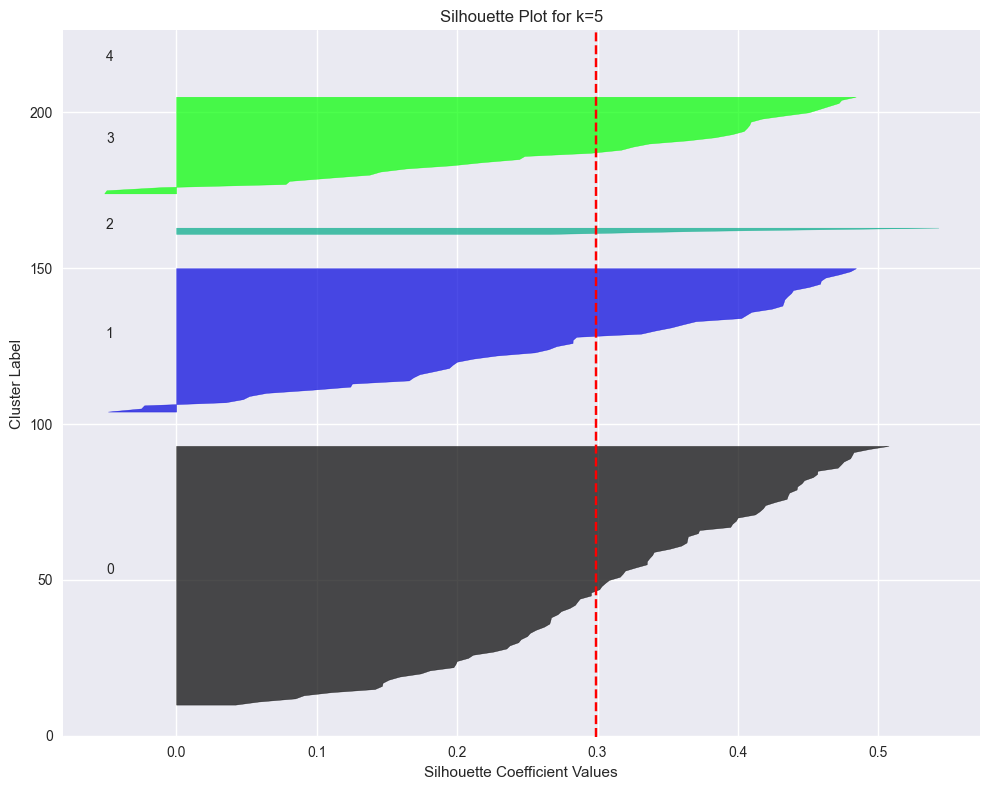

Average silhouette score: 0.299
Number of countries per cluster:
  Cluster 0: 84 countries
  Cluster 1: 47 countries
  Cluster 2: 3 countries
  Cluster 3: 32 countries
  Cluster 4: 1 countries


In [31]:
# Detailed silhouette analysis for optimal k
optimal_k = optimal_k_silhouette
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(features_scaled)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(features_scaled, cluster_labels)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, 
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient Values')
ax.set_ylabel('Cluster Label')
ax.set_title(f'Silhouette Plot for k={optimal_k}')
ax.axvline(x=silhouette_score(features_scaled, cluster_labels), color="red", linestyle="--")
plt.tight_layout()

# save the results
plt.savefig('../artifacts/figures/silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average silhouette score: {silhouette_score(features_scaled, cluster_labels):.3f}")
print(f"Number of countries per cluster:")
for i in range(optimal_k):
    count = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {count} countries")


### (b) Visualize Clusters in PCA and t-SNE Spaces


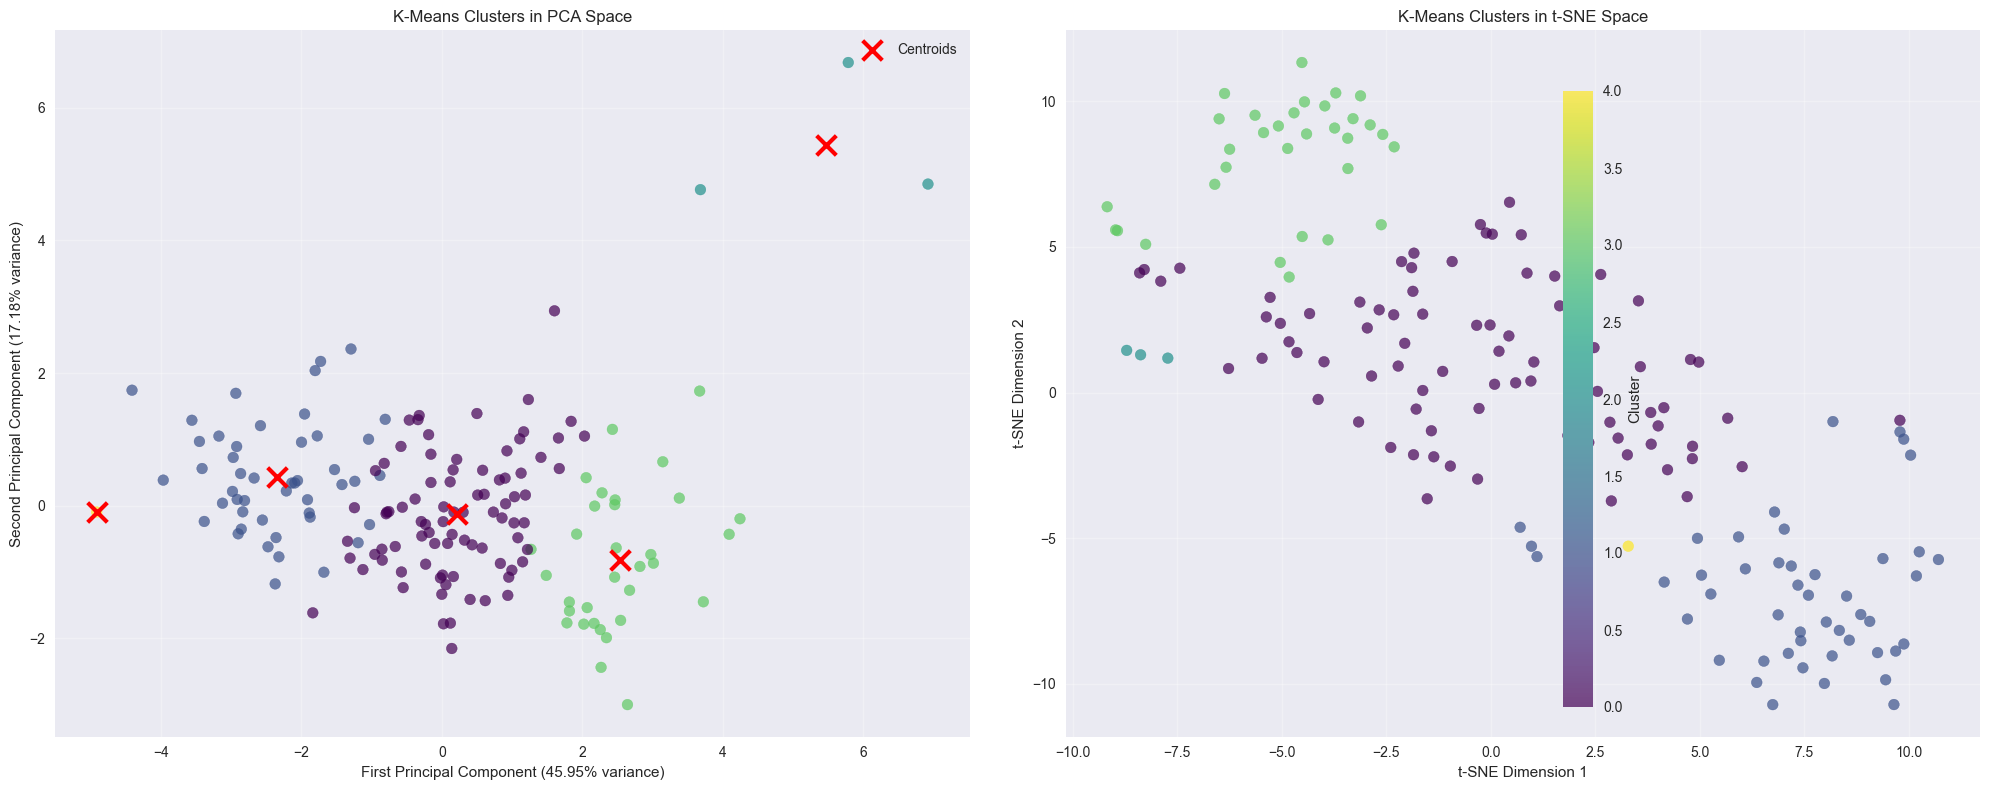

<Figure size 800x550 with 0 Axes>

In [32]:
# Visualize clusters in PCA space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA visualization
scatter = ax1.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=60)
ax1.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('K-Means Clusters in PCA Space')
ax1.grid(True, alpha=0.3)

# Add centroids
centroids_pca = pca.transform(kmeans_optimal.cluster_centers_)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax1.legend()

# t-SNE visualization
scatter = ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=60)
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_title('K-Means Clusters in t-SNE Space')
ax2.grid(True, alpha=0.3)

# Add colorbar
plt.colorbar(scatter, ax=[ax1, ax2], label='Cluster')
plt.tight_layout()
plt.show()

# save the results
plt.savefig('../artifacts/figures/kmeans_clusters.png', dpi=300, bbox_inches='tight')


### (c) Interpret Centroids and Cluster Characteristics


Cluster Centroids (scaled features):
   child_mort  exports  health  imports  income  inflation  life_expec  \
0      -0.414   -0.005  -0.236    0.026  -0.226     -0.015       0.276   
1       1.306   -0.419  -0.129   -0.133  -0.691      0.206      -1.279   
2      -0.849    4.936  -0.008    4.548   2.440     -0.504       1.227   
3      -0.823    0.183   0.830   -0.261   1.398     -0.500       1.074   
4       2.281   -0.578  -0.637   -1.222  -0.624      9.130      -1.134   

   total_fer   gdpp  
0     -0.444 -0.349  
1      1.342 -0.605  
2     -1.039  2.441  
3     -0.768  1.595  
4      1.916 -0.582  


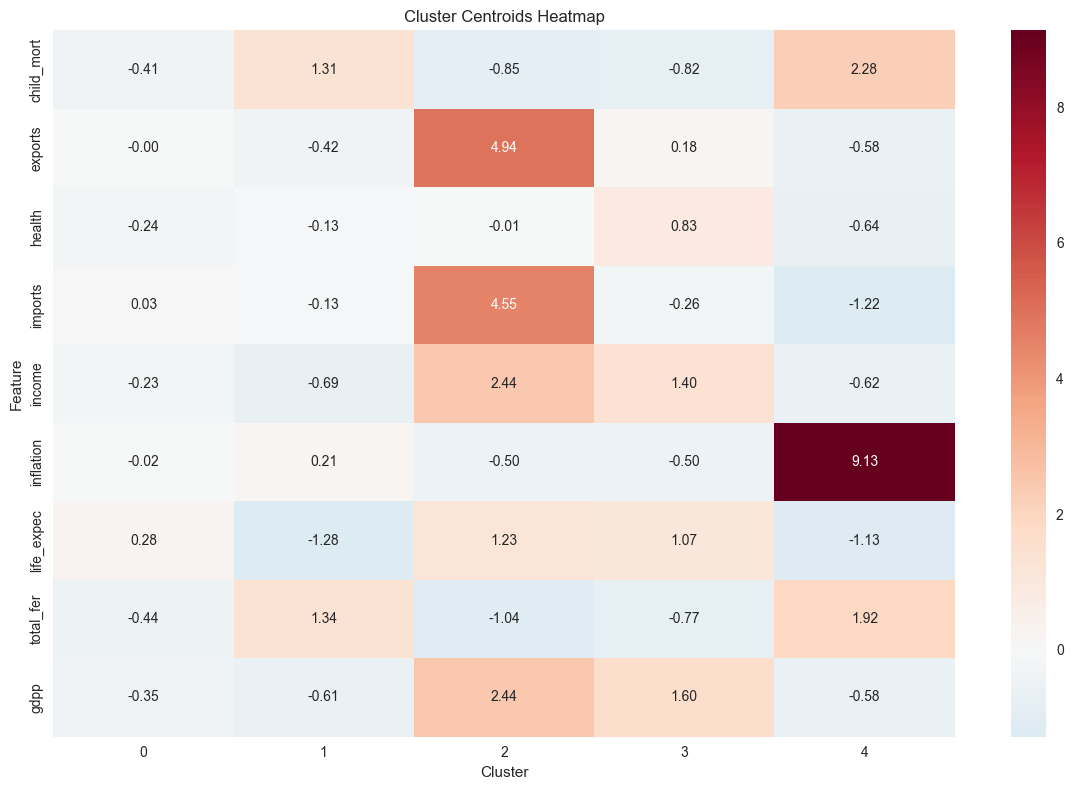

In [33]:
# Analyze cluster centroids
centroids = kmeans_optimal.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=features.columns)

print("Cluster Centroids (scaled features):")
print(centroids_df.round(3))

# Create heatmap of centroids
plt.figure(figsize=(12, 8))
sns.heatmap(centroids_df.T, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Cluster Centroids Heatmap')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()

# save the results
plt.savefig('../artifacts/figures/cluster_centroids_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Analyze cluster characteristics
cluster_analysis = df_clean.copy()
cluster_analysis['cluster'] = cluster_labels

print("Cluster Analysis:")
for i in range(optimal_k):
    cluster_data = cluster_analysis[cluster_analysis['cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} countries):")
    print(f"  Countries: {', '.join(cluster_data['country'].head(10).tolist())}")
    if len(cluster_data) > 10:
        print(f"  ... and {len(cluster_data) - 10} more")
    
    # Key statistics
    print(f"  Average GDP per capita: ${cluster_data['gdpp'].mean():.0f}")
    print(f"  Average child mortality: {cluster_data['child_mort'].mean():.1f}")
    print(f"  Average life expectancy: {cluster_data['life_expec'].mean():.1f}")
    print(f"  Average income: ${cluster_data['income'].mean():.0f}")


Cluster Analysis:

Cluster 0 (84 countries):
  Countries: Albania, Algeria, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahrain, Bangladesh, Barbados, Belarus
  ... and 74 more
  Average GDP per capita: $6582
  Average child mortality: 21.6
  Average life expectancy: 73.0
  Average income: $12801

Cluster 1 (47 countries):
  Countries: Afghanistan, Angola, Benin, Botswana, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros
  ... and 37 more
  Average GDP per capita: $1900
  Average child mortality: 90.8
  Average life expectancy: 59.2
  Average income: $3871

Cluster 2 (3 countries):
  Countries: Luxembourg, Malta, Singapore
  Average GDP per capita: $57567
  Average child mortality: 4.1
  Average life expectancy: 81.4
  Average income: $64033

Cluster 3 (32 countries):
  Countries: Australia, Austria, Bahamas, Belgium, Brunei, Canada, Cyprus, Czech Republic, Denmark, Finland
  ... and 22 more
  Average GDP per capita: $42119
  Average child mortality: 5.

## Section 3: DBSCAN Clustering


### (a) Parameter Tuning for DBSCAN


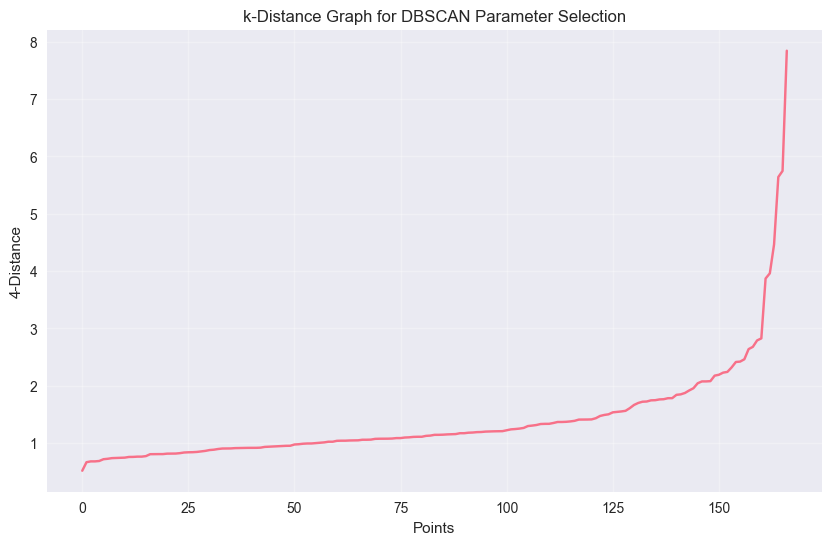

DBSCAN Parameter Testing:
eps	min_samples	n_clusters	n_noise	silhouette
------------------------------------------------------------
0.5	3		1		162		-1.000
0.5	4		0		167		-1.000
0.5	5		0		167		-1.000
0.5	6		0		167		-1.000
0.5	7		0		167		-1.000
1.0	3		6		72		0.012
1.0	4		4		84		-0.032
1.0	5		3		94		-0.025
1.0	6		2		113		0.009
1.0	7		2		118		-0.020
1.5	3		2		25		0.154
1.5	4		1		29		-1.000
1.5	5		1		30		-1.000
1.5	6		1		31		-1.000
1.5	7		1		31		-1.000
2.0	3		1		11		-1.000
2.0	4		1		12		-1.000
2.0	5		1		15		-1.000
2.0	6		1		15		-1.000
2.0	7		1		17		-1.000
2.5	3		1		6		-1.000
2.5	4		1		6		-1.000
2.5	5		1		6		-1.000
2.5	6		1		6		-1.000
2.5	7		1		6		-1.000
3.0	3		1		6		-1.000
3.0	4		1		6		-1.000
3.0	5		1		6		-1.000
3.0	6		1		6		-1.000
3.0	7		1		6		-1.000


In [35]:
# DBSCAN parameter tuning
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
k = 4  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{k}-Distance')
plt.title('k-Distance Graph for DBSCAN Parameter Selection')
plt.grid(True, alpha=0.3)

# save the results
plt.savefig('../artifacts/figures/k_distance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

# Find elbow point for eps
eps_candidates = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
min_samples_candidates = [3, 4, 5, 6, 7]

print("DBSCAN Parameter Testing:")
print("eps\tmin_samples\tn_clusters\tn_noise\tsilhouette")
print("-" * 60)

best_score = -1
best_params = None
best_labels = None

for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:  # Only calculate silhouette if we have clusters
            silhouette = silhouette_score(features_scaled, labels)
        else:
            silhouette = -1
            
        print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\t{silhouette:.3f}")
        
        if silhouette > best_score:
            best_score = silhouette
            best_params = (eps, min_samples)
            best_labels = labels


In [36]:
# Apply best DBSCAN parameters
if best_params is not None:
    eps_best, min_samples_best = best_params
    dbscan_best = DBSCAN(eps=eps_best, min_samples=min_samples_best)
    dbscan_labels = dbscan_best.fit_predict(features_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"\nBest DBSCAN Parameters:")
    print(f"eps: {eps_best}, min_samples: {min_samples_best}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Silhouette score: {best_score:.3f}")
else:
    print("No suitable DBSCAN parameters found")



Best DBSCAN Parameters:
eps: 1.5, min_samples: 3
Number of clusters: 2
Number of noise points: 25
Silhouette score: 0.154


### (b) Visualize DBSCAN Results


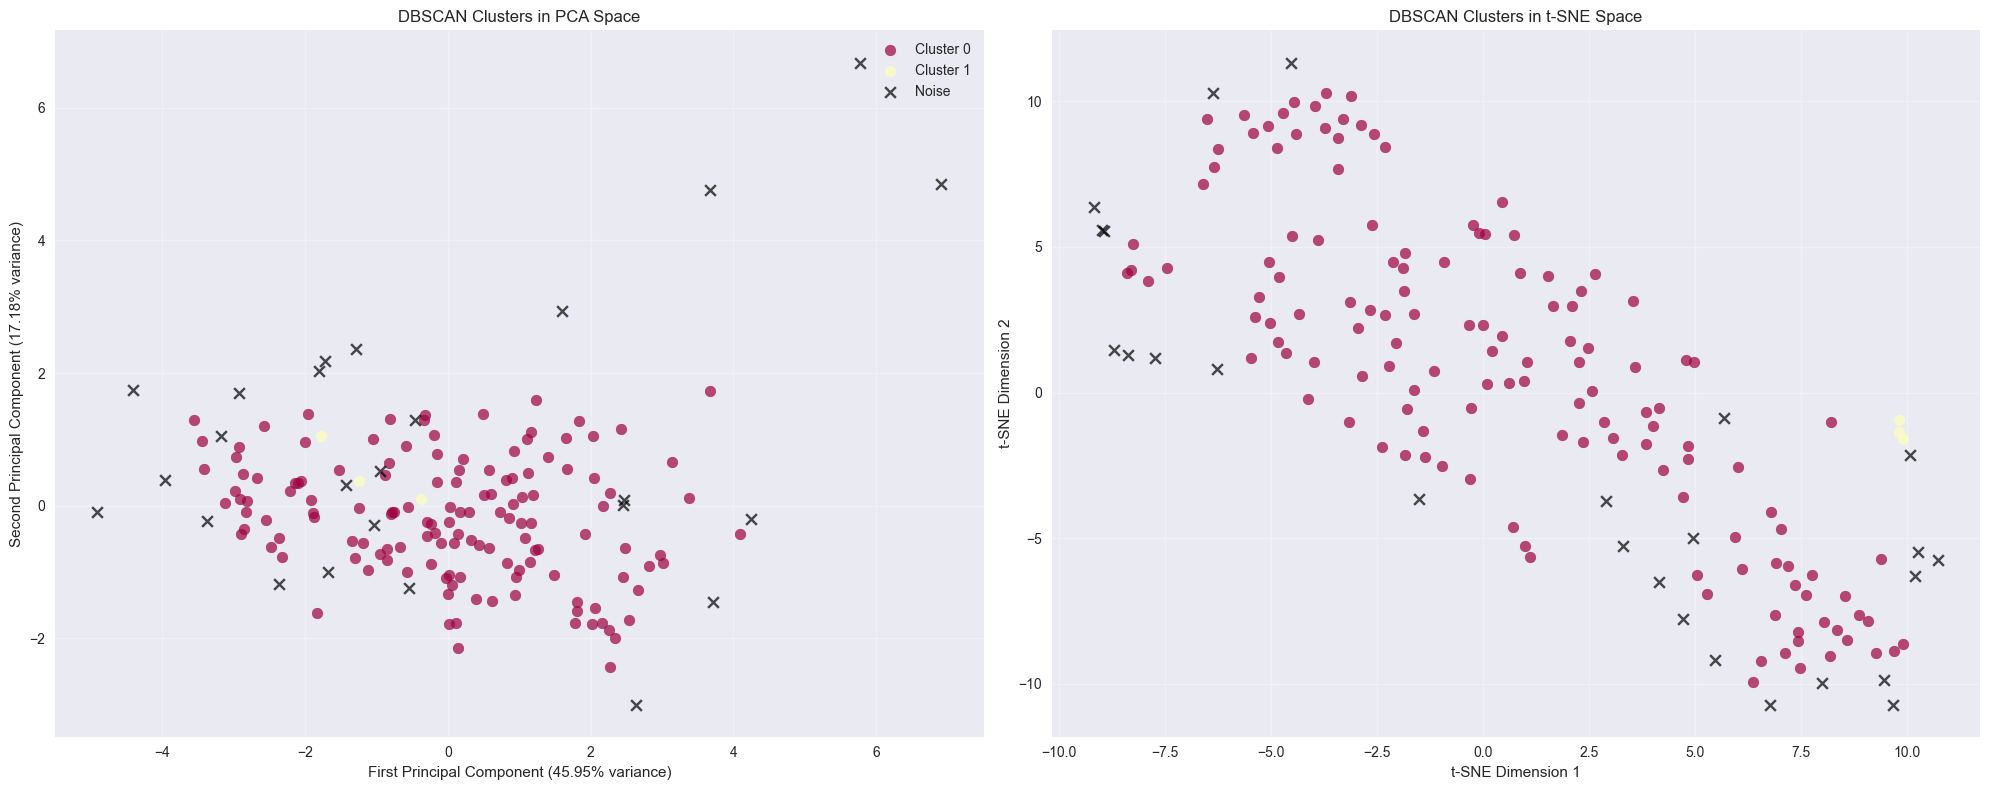

In [37]:
# Visualize DBSCAN clusters
if best_params is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # PCA visualization
    unique_labels = set(dbscan_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = 'black'
            marker = 'x'
            label = 'Noise'
        else:
            marker = 'o'
            label = f'Cluster {k}'
            
        class_member_mask = (dbscan_labels == k)
        xy = pca_result[class_member_mask]
        ax1.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7, label=label)
    
    ax1.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title('DBSCAN Clusters in PCA Space')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # t-SNE visualization
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'
            
        class_member_mask = (dbscan_labels == k)
        xy = tsne_result[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7)
    
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    ax2.set_title('DBSCAN Clusters in t-SNE Space')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()

    # save the results
    plt.savefig('../artifacts/figures/dbscan_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()


## Section 4: Algorithm Comparison


Algorithm Comparison:
  Algorithm  Number of Clusters  Noise Points  Silhouette Score  \
0   K-Means                   5             0             0.299   
1    DBSCAN                   2            25             0.154   

   Calinski-Harabasz Score  Davies-Bouldin Score  
0                   57.654                 0.872  
1                    6.482                 2.814  


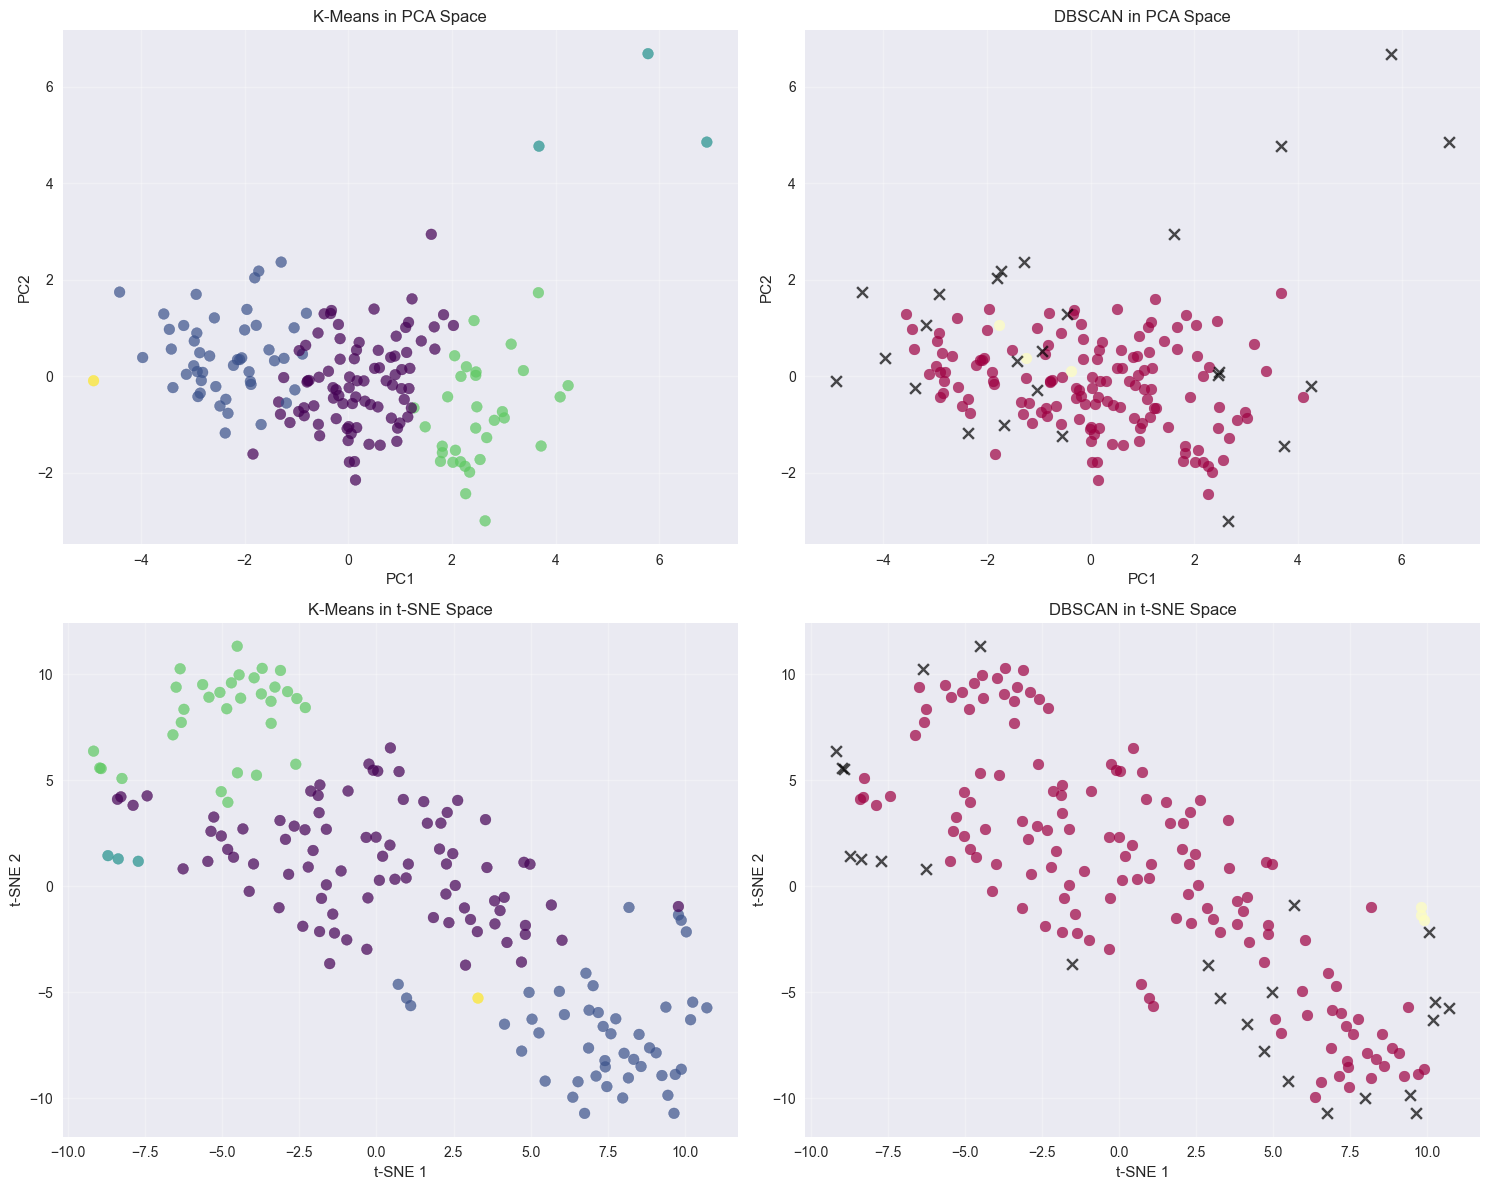

In [38]:
# Compare K-Means vs DBSCAN
if best_params is not None:
    # Calculate metrics for both algorithms
    kmeans_silhouette = silhouette_score(features_scaled, cluster_labels)
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    
    kmeans_calinski = calinski_harabasz_score(features_scaled, cluster_labels)
    dbscan_calinski = calinski_harabasz_score(features_scaled, dbscan_labels)
    
    kmeans_davies = davies_bouldin_score(features_scaled, cluster_labels)
    dbscan_davies = davies_bouldin_score(features_scaled, dbscan_labels)
    
    # Create comparison table
    comparison_data = {
        'Algorithm': ['K-Means', 'DBSCAN'],
        'Number of Clusters': [optimal_k, n_clusters],
        'Noise Points': [0, n_noise],
        'Silhouette Score': [kmeans_silhouette, dbscan_silhouette],
        'Calinski-Harabasz Score': [kmeans_calinski, dbscan_calinski],
        'Davies-Bouldin Score': [kmeans_davies, dbscan_davies]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Algorithm Comparison:")
    print(comparison_df.round(3))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # K-Means in PCA
    axes[0, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=60)
    axes[0, 0].set_title('K-Means in PCA Space')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')
    axes[0, 0].grid(True, alpha=0.3)
    
    # DBSCAN in PCA
    unique_labels = set(dbscan_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'
        class_member_mask = (dbscan_labels == k)
        xy = pca_result[class_member_mask]
        axes[0, 1].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7)
    axes[0, 1].set_title('DBSCAN in PCA Space')
    axes[0, 1].set_xlabel('PC1')
    axes[0, 1].set_ylabel('PC2')
    axes[0, 1].grid(True, alpha=0.3)
    
    # K-Means in t-SNE
    axes[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=60)
    axes[1, 0].set_title('K-Means in t-SNE Space')
    axes[1, 0].set_xlabel('t-SNE 1')
    axes[1, 0].set_ylabel('t-SNE 2')
    axes[1, 0].grid(True, alpha=0.3)
    
    # DBSCAN in t-SNE
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'
        class_member_mask = (dbscan_labels == k)
        xy = tsne_result[class_member_mask]
        axes[1, 1].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7)
    axes[1, 1].set_title('DBSCAN in t-SNE Space')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()

    # save the results
    plt.savefig('../artifacts/figures/Compare_all_dimensionality_reduction_methods.png', dpi=300, bbox_inches='tight')
    plt.show()


## Section 5: Interpretation & Insights


In [39]:
# Assign meaningful labels to clusters based on socio-economic characteristics
if best_params is not None:
    # Analyze K-Means clusters
    kmeans_analysis = df_clean.copy()
    kmeans_analysis['cluster'] = cluster_labels
    
    print("K-Means Cluster Interpretation:")
    for i in range(optimal_k):
        cluster_data = kmeans_analysis[kmeans_analysis['cluster'] == i]
        
        # Determine cluster type based on key indicators
        avg_gdpp = cluster_data['gdpp'].mean()
        avg_child_mort = cluster_data['child_mort'].mean()
        avg_life_expec = cluster_data['life_expec'].mean()
        avg_income = cluster_data['income'].mean()
        
        if avg_gdpp > 20000 and avg_child_mort < 20 and avg_life_expec > 75:
            cluster_type = "Developed Nations"
        elif avg_gdpp > 5000 and avg_child_mort < 50 and avg_life_expec > 65:
            cluster_type = "Emerging Economies"
        else:
            cluster_type = "Developing Nations"
        
        print(f"\nCluster {i} - {cluster_type}:")
        print(f"  GDP per capita: ${avg_gdpp:.0f}")
        print(f"  Child mortality: {avg_child_mort:.1f}")
        print(f"  Life expectancy: {avg_life_expec:.1f}")
        print(f"  Income: ${avg_income:.0f}")
        print(f"  Sample countries: {', '.join(cluster_data['country'].head(5).tolist())}")
    
    # Analyze DBSCAN clusters
    dbscan_analysis = df_clean.copy()
    dbscan_analysis['cluster'] = dbscan_labels
    
    print(f"\n\nDBSCAN Cluster Interpretation:")
    print(f"Total clusters: {n_clusters}")
    print(f"Noise points: {n_noise}")
    
    for i in range(n_clusters):
        cluster_data = dbscan_analysis[dbscan_analysis['cluster'] == i]
        if len(cluster_data) > 0:
            avg_gdpp = cluster_data['gdpp'].mean()
            avg_child_mort = cluster_data['child_mort'].mean()
            avg_life_expec = cluster_data['life_expec'].mean()
            
            if avg_gdpp > 20000 and avg_child_mort < 20:
                cluster_type = "Developed Nations"
            elif avg_gdpp > 5000 and avg_child_mort < 50:
                cluster_type = "Emerging Economies"
            else:
                cluster_type = "Developing Nations"
            
            print(f"\nCluster {i} - {cluster_type} ({len(cluster_data)} countries):")
            print(f"  GDP per capita: ${avg_gdpp:.0f}")
            print(f"  Child mortality: {avg_child_mort:.1f}")
            print(f"  Life expectancy: {avg_life_expec:.1f}")
            print(f"  Sample countries: {', '.join(cluster_data['country'].head(5).tolist())}")
    
    # Noise points analysis
    noise_data = dbscan_analysis[dbscan_analysis['cluster'] == -1]
    if len(noise_data) > 0:
        print(f"\nNoise Points ({len(noise_data)} countries):")
        print(f"  These countries don't fit well into any cluster")
        print(f"  Sample countries: {', '.join(noise_data['country'].head(10).tolist())}")
        print(f"  Average GDP per capita: ${noise_data['gdpp'].mean():.0f}")
        print(f"  Average child mortality: {noise_data['child_mort'].mean():.1f}")


K-Means Cluster Interpretation:

Cluster 0 - Emerging Economies:
  GDP per capita: $6582
  Child mortality: 21.6
  Life expectancy: 73.0
  Income: $12801
  Sample countries: Albania, Algeria, Antigua and Barbuda, Argentina, Armenia

Cluster 1 - Developing Nations:
  GDP per capita: $1900
  Child mortality: 90.8
  Life expectancy: 59.2
  Income: $3871
  Sample countries: Afghanistan, Angola, Benin, Botswana, Burkina Faso

Cluster 2 - Developed Nations:
  GDP per capita: $57567
  Child mortality: 4.1
  Life expectancy: 81.4
  Income: $64033
  Sample countries: Luxembourg, Malta, Singapore

Cluster 3 - Developed Nations:
  GDP per capita: $42119
  Child mortality: 5.2
  Life expectancy: 80.1
  Income: $44022
  Sample countries: Australia, Austria, Bahamas, Belgium, Brunei

Cluster 4 - Developing Nations:
  GDP per capita: $2330
  Child mortality: 130.0
  Life expectancy: 60.5
  Income: $5150
  Sample countries: Nigeria


DBSCAN Cluster Interpretation:
Total clusters: 2
Noise points: 25

C

## Key insights and conclusions

### 01.DIMENSIONALITY REDUCTION ROLE:
- PCA revealed linear relationships in socio-economic data
- t-SNE captured non-linear patterns and local structures
- Both methods helped visualize high-dimensional country data

### 02.CLUSTERING ALGORITHM COMPARISON:
- K-Means: Good for spherical clusters, requires predefined k
- DBSCAN: Handles noise, finds arbitrary-shaped clusters
- Both algorithms revealed meaningful country groupings

### 03.SOCIO-ECONOMIC PATTERNS DISCOVERED:
- Clear separation between developed, emerging, and developing nations
- GDP per capita and child mortality are key differentiators
- Life expectancy correlates strongly with economic development

### 04.ALGORITHM STRENGTHS:
- K-Means: Stable, interpretable centroids, good for analysis
- DBSCAN: Identifies outliers, flexible cluster shapes
- Both provide complementary insights into country data

### 05.PRACTICAL IMPLICATIONS:
- Can be used for policy targeting and development assistance
- Helps identify countries with similar development challenges
- Useful for economic analysis and international comparisons
